In [1]:
EPOCHS = 50
BATCH_SIZE = 32

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.4)

In [3]:
from fastai.vision import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/XRayDataSet/'
#THIS PATH SHOULD HAVE TWO FOLDERS: COVID and NON-COVID (w/e)

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [7]:
import torch
import urllib
import zipfile
import torchvision
from torchvision import transforms
from torchsummary import summary


In [8]:
def conv_block(ni, nf, size=3, stride=1):
  for_pad = lambda s: s if s > 2 else 3
  return nn.Sequential(
      nn.Conv2d(ni, nf, kernel_size=size, stride=stride, padding=(for_pad(size) - 1)//2, bias=False), 
      nn.BatchNorm2d(nf),
      nn.LeakyReLU(negative_slope=0.1, inplace=True)
      )
        
def triple_conv(ni, nf):
  return nn.Sequential(
      conv_block(ni, nf),
      conv_block(nf, ni, size=1),  
      conv_block(ni, nf)
  )
        
def maxpooling():
  return nn.MaxPool2d(2, stride=2)

In [9]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.model = nn.Sequential(
          conv_block(3, 8),
          maxpooling(),
          conv_block(8, 16),
          maxpooling(),
          triple_conv(16, 32),
          maxpooling(),
          triple_conv(32, 64),
          maxpooling(),
          triple_conv(64, 128),
          maxpooling(),
          triple_conv(128, 256),
          conv_block(256, 128, size=1),
          conv_block(128, 256),
          conv_layer(256, 2),
          Flatten(),
          nn.Linear(338, 2),  #[covid,non-covid]
          #Flatten(),
          # nn.Softmax(dim=1)   # get value between 0 and 1
      )
        
    def forward(self, x):
        z = self.model(x)
        return z

In [13]:
from sklearn.metrics import confusion_matrix
def c_mat(y_true, y_pred):
    
    # print('y_pred: ' + str(y_pred))
    # _p = [int(1 if i[0] > 0 else 0) for i in y_pred]
    
    # print('target: ' + str(_t))
    # print('predicted: ' + str(_p))
    
    
    #_t = [int(1 if i[0] < i[1] else 0) for i in y_true]
    #_p = [int(1 if i[0] < i[1] else 0) for i in y_pred]
    #tn, fp, fn, tp = confusion_matrix(_t, _p, labels=[0, 1]).ravel()

    #print(y_pred)
    
    _t = [int(1 if i==1 else 0) for i in y_true]
    _p = [int(1 if i[0] < i[1] else 0) for i in y_pred]
    tn, fp, fn, tp = confusion_matrix(_t, _p, labels=[0, 1]).ravel()
    #print('t: ' + str(_t))
    #print('p: ' + str(_p))
    #print('tn: ' + str(tn), ' fp: ' + str(fp), ' fn: ' + str(fn), ' tp: ' + str(tp))
    # print('fp: ' + str(fp))
    # print('fn: ' + str(fn))
    # print('tp: ' + str(tp))
    return tn, fp, fn, tp

In [37]:
def evaluate_model_on_val_set(model, val_loader, criterion, val_loss_arr, val_acc_arr):
    running_loss = 0.0
    running_correct = 0.0
    
    count = 0
    count2=0
    img_cnt=0
    precision=0
    recall=0
    accuracy=0
    f1=0
    with torch.no_grad():
        for mini_batch in val_loader:
            images, labels = mini_batch
            output = ae(images)
            _, predicted = torch.max(output, 1)
            #count += len(output)
            count+=1
            img_cnt+=len(output)

            tn, fp, fn, tp = c_mat(labels, output)
            
            precision += tp/(tp+fp)
            recall += tp/(tp+fn)
            accuracy+=(tp+tn)/(tp+fp+tn+fn)
            count2+=len(output)
            
            loss = criterion(output, labels)
            
            running_loss += loss.item()
            num_correct = (labels == predicted).sum()
            running_correct += num_correct.item()
                        
    val_loss = running_loss/len(val_dataset1)
    #val_acc = 100.00 * running_correct/len(val_dataset1)
    #epoch_loss = running_loss/count
    #epoch_acc = running_correct/img_cnt
    val_acc = accuracy/count
    val_prec=precision/count
    val_recall=recall/count
    val_f1=2/((1/val_recall) + (1/val_prec))
    #epoch_loss = running_loss/count
    #epoch_acc = 100.00 * running_correct/count
    

    val_loss_arr.append(val_loss)
    val_acc_arr.append(val_acc)
    
    
    print(" - Validation dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f. Epoch Accuracy: %.3f. Epoch Precision: %.3f. Epoch Recall: %.3f. Epoch F1: %.3f"
                  %(running_correct, count2, val_acc, val_loss, val_acc, val_prec, val_recall, val_f1))
    return val_loss, val_acc, val_prec, val_recall, val_f1

# **40**

In [89]:
image_dataset = torchvision.datasets.ImageFolder(root=path)
train_dataset1, val_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=40)

for i in range(len(train_dataset1)):
    train_dataset1[i] = (train_transforms(train_dataset1[i][0]), train_dataset1[i][1])

for i in range(len(val_dataset1)):
    val_dataset1[i] = (val_transforms(val_dataset1[i][0]), val_dataset1[i][1])

train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset1, batch_size=BATCH_SIZE)
val_loader1 = torch.utils.data.DataLoader(dataset=val_dataset1, batch_size=BATCH_SIZE)

In [90]:
#last layer fine tune only
#trainable false. last layer trainable true
EPOCHS = 30
train_loss_arr1 = []
train_acc_arr1 = []
val_loss_arr1 = []
val_acc_arr1 = []
train_prec_arr1=[]
train_recall_arr1=[]
train_f1_arr1=[]
#ae=model
ae = AE()
criterion = nn.CrossEntropyLoss()
#optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
optimizer = optim.Adam(ae.parameters(), lr = 3e-3)

for i in range(EPOCHS):
    running_loss = 0.0
    running_correct = 0.0
    count = 0
    img_cnt=0
    precision=0
    recall=0
    f1=0
    accuracy=0


    for data in train_loader1:
        print(".", end ="")
        images, labels = data

        optimizer.zero_grad()
        
        output = ae(images)

        _, predicted = torch.max(output, 1)
        #count += len(output)'
        count+=1
        img_cnt+=len(output)

        tn, fp, fn, tp = c_mat(labels, output)
        
        precision += tp/(tp+fp)
        recall += tp/(tp+fn)
        accuracy+=(tp+tn)/(tp+fp+tn+fn)
        #f1 += 2/((1/recall) + (1/precision))
        

        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_correct = (labels == predicted).sum()
        running_correct += num_correct.item()

    epoch_loss = running_loss/count
    #epoch_acc = running_correct/img_cnt
    epoch_acc = accuracy/count
    epoch_prec=precision/count 
    epoch_recall=recall/count 
    #epoch_f1=f1/count 
    epoch_f1=2/((1/epoch_recall) + (1/epoch_prec))

    train_loss_arr1.append(epoch_loss)
    train_acc_arr1.append(epoch_acc)


    train_prec_arr1.append(epoch_prec)
    train_recall_arr1.append(epoch_recall)
    train_f1_arr1.append(epoch_f1)
    #print('tn: ' + str(tn), ' fp: ' + str(fp), ' fn: ' + str(fn), ' tp: ' + str(tp))

    print("\nEpoch " + str(i+1) + " - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f. Epoch Accuracy: %.3f. Epoch Precision: %.3f. Epoch Recall: %.3f. Epoch F1: %.3f"
                  %(running_correct, img_cnt, epoch_acc, epoch_loss, epoch_acc, epoch_prec, epoch_recall, epoch_f1))
    
    #evaluate_model_on_val_set(ae, val_loader, criterion, i, val_loss_arr, val_acc_arr)

..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


......

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


......
Epoch 1 - Training dataset. Got 390 out of 504 images correctly (0.775%). Epoch loss: 0.405. Epoch Accuracy: 0.775. Epoch Precision: nan. Epoch Recall: 0.286. Epoch F1: nan
................
Epoch 2 - Training dataset. Got 456 out of 504 images correctly (0.904%). Epoch loss: 0.235. Epoch Accuracy: 0.904. Epoch Precision: 0.784. Epoch Recall: 0.795. Epoch F1: 0.789
................
Epoch 3 - Training dataset. Got 468 out of 504 images correctly (0.928%). Epoch loss: 0.161. Epoch Accuracy: 0.928. Epoch Precision: 0.848. Epoch Recall: 0.841. Epoch F1: 0.844
................
Epoch 4 - Training dataset. Got 479 out of 504 images correctly (0.950%). Epoch loss: 0.138. Epoch Accuracy: 0.950. Epoch Precision: 0.884. Epoch Recall: 0.889. Epoch F1: 0.886
................
Epoch 5 - Training dataset. Got 495 out of 504 images correctly (0.982%). Epoch loss: 0.062. Epoch Accuracy: 0.982. Epoch Precision: 0.967. Epoch Recall: 0.951. Epoch F1: 0.959
................
Epoch 6 - Training dataset.

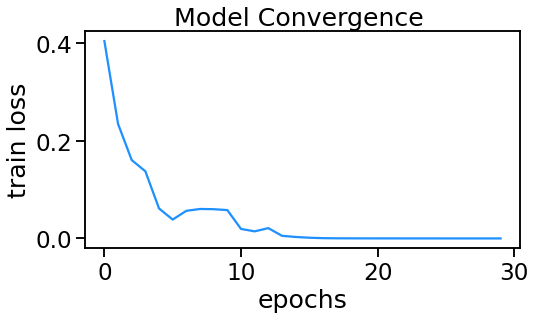

In [92]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr1)),train_loss_arr1,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

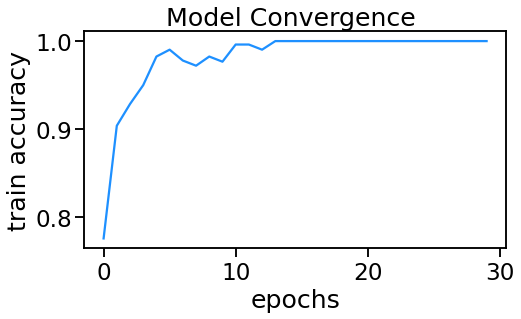

In [93]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr1)),train_acc_arr1,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

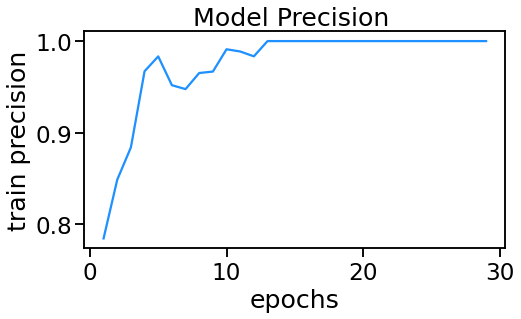

In [94]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr1)),train_prec_arr1,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

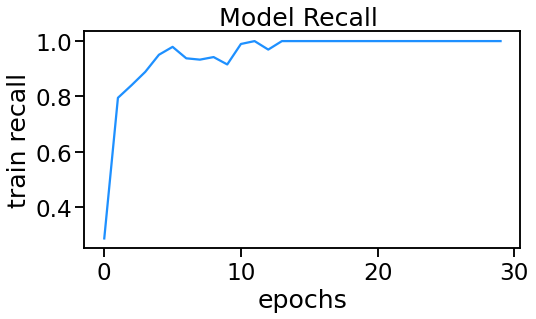

In [95]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr1)),train_recall_arr1,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

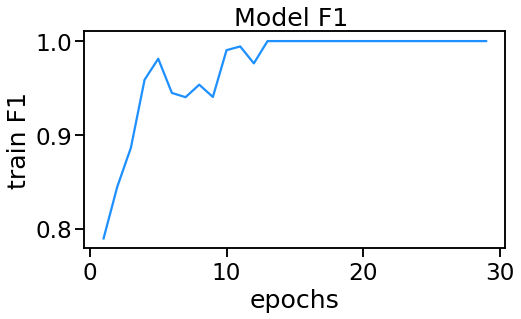

In [96]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr1)),train_f1_arr1,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [91]:
val_loss1, val_acc1, val_prec1, val_recall1, val_f11 = evaluate_model_on_val_set(ae, val_loader1, criterion, val_loss_arr1, val_acc_arr1)

 - Validation dataset. Got 125 out of 126 images correctly (0.992%). Epoch loss: 0.001. Epoch Accuracy: 0.992. Epoch Precision: 1.000. Epoch Recall: 0.964. Epoch F1: 0.982


# **45**

In [73]:
image_dataset = torchvision.datasets.ImageFolder(root=path)
train_dataset1, val_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=45)

for i in range(len(train_dataset1)):
    train_dataset1[i] = (train_transforms(train_dataset1[i][0]), train_dataset1[i][1])

for i in range(len(val_dataset1)):
    val_dataset1[i] = (val_transforms(val_dataset1[i][0]), val_dataset1[i][1])

train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset1, batch_size=BATCH_SIZE)
val_loader1 = torch.utils.data.DataLoader(dataset=val_dataset1, batch_size=BATCH_SIZE)

In [74]:
#last layer fine tune only
#trainable false. last layer trainable true
EPOCHS = 30
train_loss_arr2 = []
train_acc_arr2 = []
val_loss_arr2 = []
val_acc_arr2 = []
train_prec_arr2=[]
train_recall_arr2=[]
train_f1_arr2=[]
#ae=model
ae = AE()
criterion = nn.CrossEntropyLoss()
#optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
optimizer = optim.Adam(ae.parameters(), lr = 3e-3)

for i in range(EPOCHS):
    running_loss = 0.0
    running_correct = 0.0
    count = 0
    img_cnt=0
    precision=0
    recall=0
    f1=0
    accuracy=0


    for data in train_loader1:
        print(".", end ="")
        images, labels = data

        optimizer.zero_grad()
        
        output = ae(images)

        _, predicted = torch.max(output, 1)
        #count += len(output)'
        count+=1
        img_cnt+=len(output)

        tn, fp, fn, tp = c_mat(labels, output)
        
        precision += tp/(tp+fp)
        recall += tp/(tp+fn)
        accuracy+=(tp+tn)/(tp+fp+tn+fn)
        #f1 += 2/((1/recall) + (1/precision))
        

        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_correct = (labels == predicted).sum()
        running_correct += num_correct.item()

    epoch_loss = running_loss/count
    #epoch_acc = running_correct/img_cnt
    epoch_acc = accuracy/count
    epoch_prec=precision/count 
    epoch_recall=recall/count 
    #epoch_f1=f1/count 
    epoch_f1=2/((1/epoch_recall) + (1/epoch_prec))

    train_loss_arr2.append(epoch_loss)
    train_acc_arr2.append(epoch_acc)


    train_prec_arr2.append(epoch_prec)
    train_recall_arr2.append(epoch_recall)
    train_f1_arr2.append(epoch_f1)
    #print('tn: ' + str(tn), ' fp: ' + str(fp), ' fn: ' + str(fn), ' tp: ' + str(tp))

    print("\nEpoch " + str(i+1) + " - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f. Epoch Accuracy: %.3f. Epoch Precision: %.3f. Epoch Recall: %.3f. Epoch F1: %.3f"
                  %(running_correct, img_cnt, epoch_acc, epoch_loss, epoch_acc, epoch_prec, epoch_recall, epoch_f1))
    
    #evaluate_model_on_val_set(ae, val_loader, criterion, i, val_loss_arr, val_acc_arr)

..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


.........

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


...
Epoch 1 - Training dataset. Got 411 out of 504 images correctly (0.817%). Epoch loss: 0.348. Epoch Accuracy: 0.817. Epoch Precision: nan. Epoch Recall: 0.467. Epoch F1: nan
................
Epoch 2 - Training dataset. Got 471 out of 504 images correctly (0.934%). Epoch loss: 0.175. Epoch Accuracy: 0.934. Epoch Precision: 0.887. Epoch Recall: 0.777. Epoch F1: 0.828
................
Epoch 3 - Training dataset. Got 485 out of 504 images correctly (0.962%). Epoch loss: 0.117. Epoch Accuracy: 0.962. Epoch Precision: 0.890. Epoch Recall: 0.912. Epoch F1: 0.901
................
Epoch 4 - Training dataset. Got 497 out of 504 images correctly (0.986%). Epoch loss: 0.050. Epoch Accuracy: 0.986. Epoch Precision: 0.950. Epoch Recall: 0.969. Epoch F1: 0.959
................
Epoch 5 - Training dataset. Got 494 out of 504 images correctly (0.980%). Epoch loss: 0.062. Epoch Accuracy: 0.980. Epoch Precision: 0.955. Epoch Recall: 0.935. Epoch F1: 0.945
................
Epoch 6 - Training dataset. Go

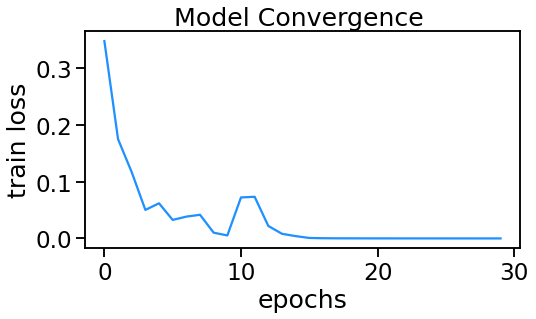

In [75]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr2)),train_loss_arr2,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

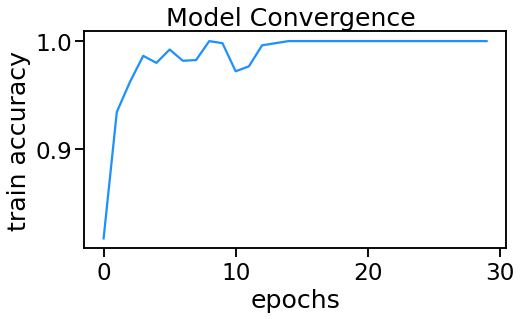

In [76]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr2)),train_acc_arr2,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

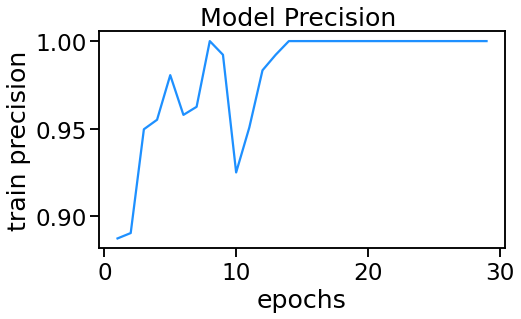

In [77]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr2)),train_prec_arr2,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

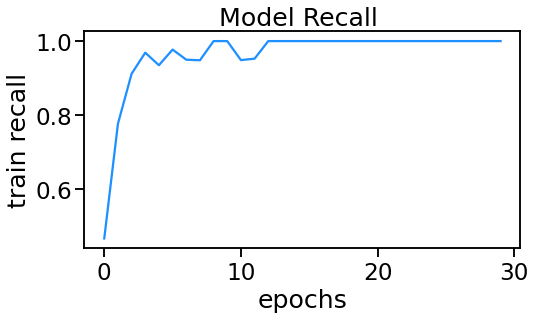

In [78]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr2)),train_recall_arr2,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

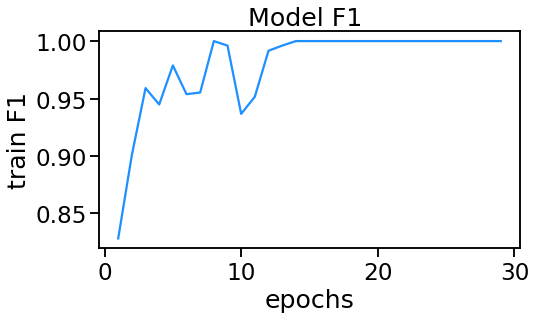

In [79]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr2)),train_f1_arr2,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [80]:
val_loss2, val_acc2, val_prec2, val_recall2, val_f12 = evaluate_model_on_val_set(ae, val_loader1, criterion, val_loss_arr2, val_acc_arr2)

 - Validation dataset. Got 124 out of 126 images correctly (0.984%). Epoch loss: 0.001. Epoch Accuracy: 0.984. Epoch Precision: 0.950. Epoch Recall: 0.950. Epoch F1: 0.950


# **50**

In [100]:
image_dataset = torchvision.datasets.ImageFolder(root=path)
train_dataset1, val_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=50)

for i in range(len(train_dataset1)):
    train_dataset1[i] = (train_transforms(train_dataset1[i][0]), train_dataset1[i][1])

for i in range(len(val_dataset1)):
    val_dataset1[i] = (val_transforms(val_dataset1[i][0]), val_dataset1[i][1])

train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset1, batch_size=BATCH_SIZE)
val_loader1 = torch.utils.data.DataLoader(dataset=val_dataset1, batch_size=BATCH_SIZE)

In [101]:
#last layer fine tune only
#trainable false. last layer trainable true
EPOCHS = 30
train_loss_arr3 = []
train_acc_arr3 = []
val_loss_arr3 = []
val_acc_arr3 = []
train_prec_arr3=[]
train_recall_arr3=[]
train_f1_arr3=[]
#ae=model
ae = AE()
criterion = nn.CrossEntropyLoss()
#optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
optimizer = optim.Adam(ae.parameters(), lr = 3e-3)

for i in range(EPOCHS):
    running_loss = 0.0
    running_correct = 0.0
    count = 0
    img_cnt=0
    precision=0
    recall=0
    f1=0
    accuracy=0


    for data in train_loader1:
        print(".", end ="")
        images, labels = data

        optimizer.zero_grad()
        
        output = ae(images)

        _, predicted = torch.max(output, 1)
        #count += len(output)'
        count+=1
        img_cnt+=len(output)

        tn, fp, fn, tp = c_mat(labels, output)
        
        precision += tp/(tp+fp)
        recall += tp/(tp+fn)
        accuracy+=(tp+tn)/(tp+fp+tn+fn)
        #f1 += 2/((1/recall) + (1/precision))
        

        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_correct = (labels == predicted).sum()
        running_correct += num_correct.item()

    epoch_loss = running_loss/count
    #epoch_acc = running_correct/img_cnt
    epoch_acc = accuracy/count
    epoch_prec=precision/count 
    epoch_recall=recall/count 
    #epoch_f1=f1/count 
    epoch_f1=2/((1/epoch_recall) + (1/epoch_prec))

    train_loss_arr3.append(epoch_loss)
    train_acc_arr3.append(epoch_acc)


    train_prec_arr3.append(epoch_prec)
    train_recall_arr3.append(epoch_recall)
    train_f1_arr3.append(epoch_f1)
    #print('tn: ' + str(tn), ' fp: ' + str(fp), ' fn: ' + str(fn), ' tp: ' + str(tp))

    print("\nEpoch " + str(i+1) + " - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f. Epoch Accuracy: %.3f. Epoch Precision: %.3f. Epoch Recall: %.3f. Epoch F1: %.3f"
                  %(running_correct, img_cnt, epoch_acc, epoch_loss, epoch_acc, epoch_prec, epoch_recall, epoch_f1))
    
    #evaluate_model_on_val_set(ae, val_loader, criterion, i, val_loss_arr, val_acc_arr)

....

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


.....

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


...
Epoch 1 - Training dataset. Got 377 out of 504 images correctly (0.751%). Epoch loss: 0.497. Epoch Accuracy: 0.751. Epoch Precision: nan. Epoch Recall: 0.206. Epoch F1: nan
................
Epoch 2 - Training dataset. Got 445 out of 504 images correctly (0.883%). Epoch loss: 0.254. Epoch Accuracy: 0.883. Epoch Precision: 0.770. Epoch Recall: 0.719. Epoch F1: 0.743
................
Epoch 3 - Training dataset. Got 471 out of 504 images correctly (0.935%). Epoch loss: 0.149. Epoch Accuracy: 0.935. Epoch Precision: 0.870. Epoch Recall: 0.870. Epoch F1: 0.870
................
Epoch 4 - Training dataset. Got 477 out of 504 images correctly (0.947%). Epoch loss: 0.112. Epoch Accuracy: 0.947. Epoch Precision: 0.909. Epoch Recall: 0.859. Epoch F1: 0.883
................
Epoch 5 - Training dataset. Got 489 out of 504 images correctly (0.971%). Epoch loss: 0.086. Epoch Accuracy: 0.971. Epoch Precision: 0.953. Epoch Recall: 0.903. Epoch F1: 0.928
................
Epoch 6 - Training dataset. Go

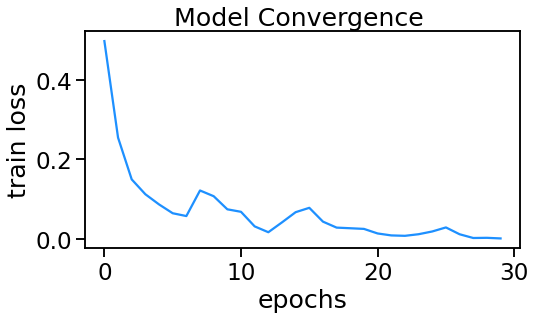

In [103]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr3)),train_loss_arr3,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

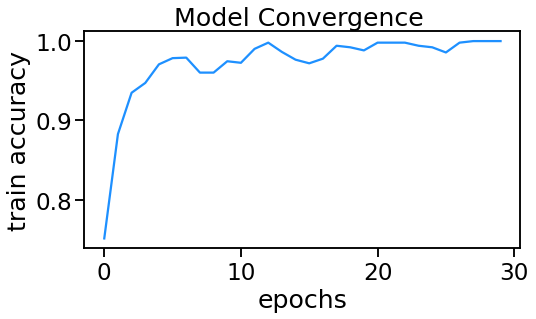

In [104]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr3)),train_acc_arr3,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

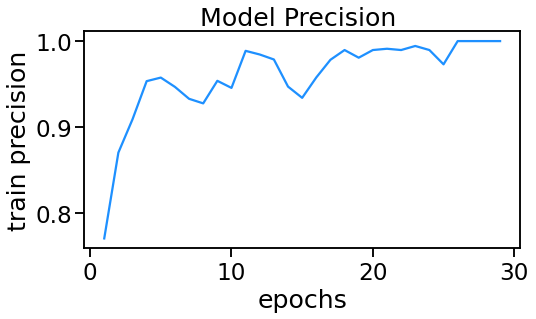

In [105]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr3)),train_prec_arr3,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

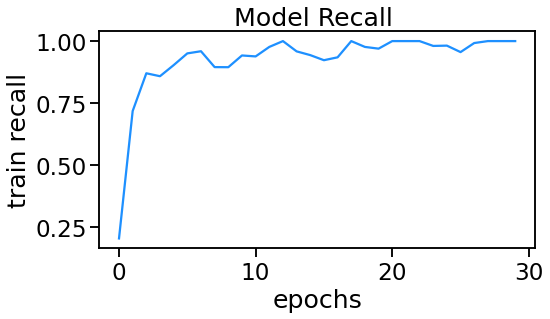

In [106]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr3)),train_recall_arr3,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

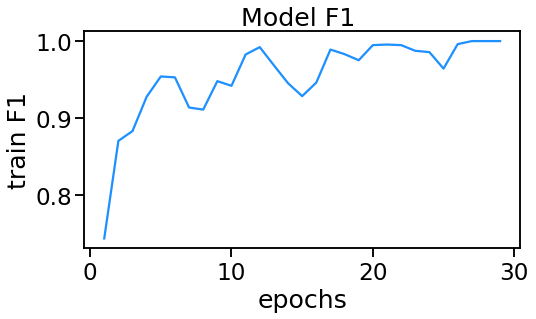

In [107]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr3)),train_f1_arr3,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [102]:
val_loss3, val_acc3, val_prec3, val_recall3, val_f13 = evaluate_model_on_val_set(ae, val_loader1, criterion, val_loss_arr3, val_acc_arr3)

 - Validation dataset. Got 123 out of 126 images correctly (0.977%). Epoch loss: 0.001. Epoch Accuracy: 0.977. Epoch Precision: 0.958. Epoch Recall: 0.917. Epoch F1: 0.937


# **Averages**

In [108]:
import numpy as np

In [109]:
train_loss_arr_avg = np.mean(np.array([train_loss_arr1, train_loss_arr2, train_loss_arr3]), axis=0)
train_acc_arr_avg = np.mean(np.array([train_acc_arr1, train_acc_arr2, train_acc_arr3]), axis=0)
train_prec_arr_avg=np.mean(np.array([train_prec_arr1, train_prec_arr2, train_prec_arr3]), axis=0)
train_recall_arr_avg=np.mean(np.array([train_recall_arr1, train_recall_arr2, train_recall_arr3]), axis=0)
train_f1_arr_avg=np.mean(np.array([train_f1_arr1, train_f1_arr2, train_f1_arr3]), axis=0)

In [110]:
print(train_loss_arr_avg[-1])
print(train_acc_arr_avg[-1])
print(train_prec_arr_avg[-1])
print(train_recall_arr_avg[-1])
print(train_f1_arr_avg[-1])

0.0002619297844148605
1.0
1.0
1.0
1.0


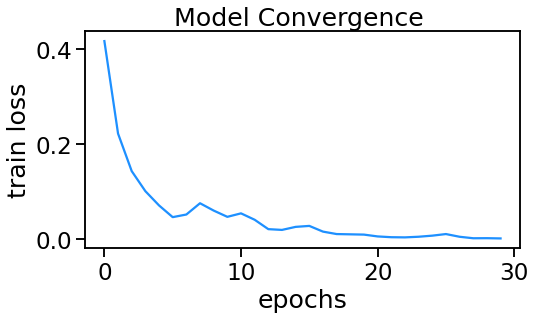

In [111]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr_avg)),train_loss_arr_avg,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

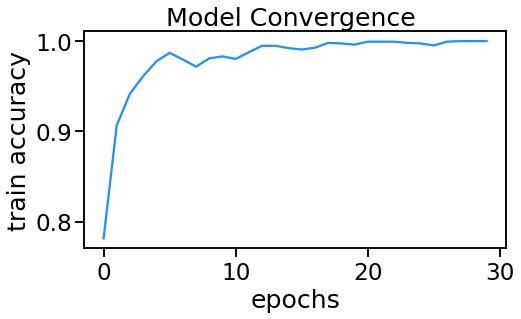

In [112]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr_avg)),train_acc_arr_avg,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

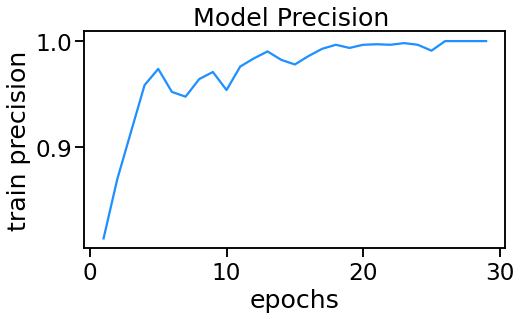

In [113]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr_avg)),train_prec_arr_avg,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

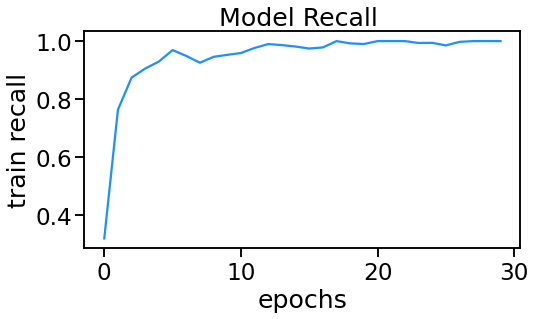

In [114]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr_avg)),train_recall_arr_avg,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

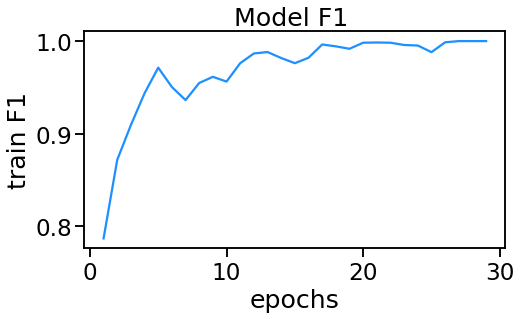

In [115]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr_avg)),train_f1_arr_avg,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [116]:
print("Test", ". Loss: ", (val_loss1+val_loss2+val_loss3)/3, ". Accuracy: ", (val_acc1+val_acc2+val_acc3)/3, ". Precision: ", (val_prec1+val_prec2+val_prec3)/3, ". Recall: ", (val_recall1+val_recall2+val_recall3)/3, ". F1-Score: ",(val_f11+val_f12+val_f13)/3)


Test . Loss:  0.0013046801645677075 . Accuracy:  0.984375 . Precision:  0.9694444444444444 . Recall:  0.9436507936507935 . F1-Score:  0.9562850729517396


In [ ]:
w# as you can see current ram is 12GB only, to increase it run below code

In [ ]:
i = []
while True:
  i.append(i)

In [ ]:
# wait for few minutes, after that you will get a prompt that your notebook got crashed, do you want to increase ram ?

In [ ]:
# in the prompt click - yes

In [ ]:
# as you see the ram increase from 12GB to 25GB

In [ ]:
#thanks for watching, keep learning 

**NOTE**: PLease allow your browser to allow show pop-ups by sites as show below 

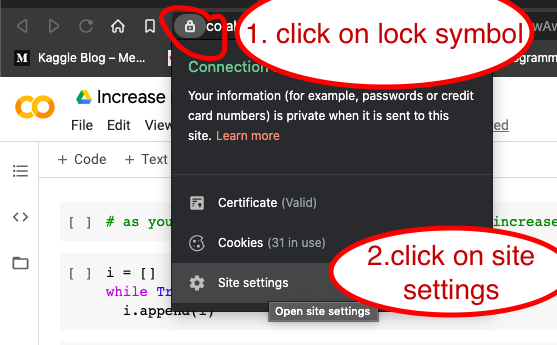

In [ ]:
#step-1

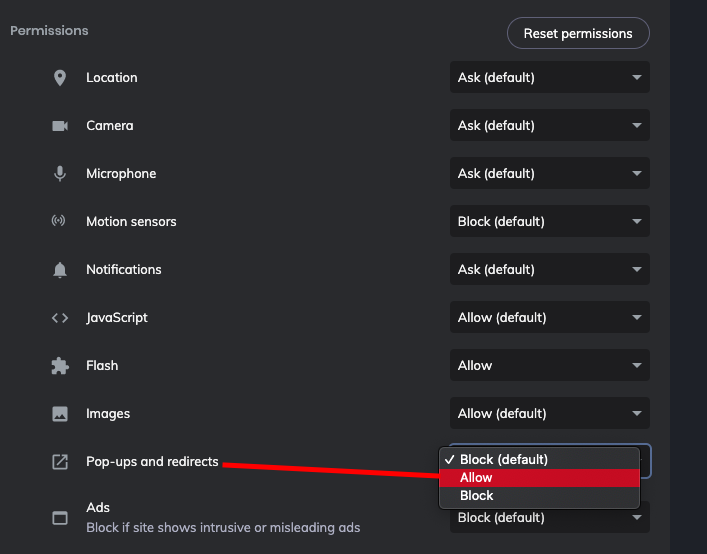

In [ ]:
#step-2